<a href="https://colab.research.google.com/github/MuhammadMazid/Human-name-classification-using-LSTM-with-PyTorch/blob/main/Human_name_classification_using_LSTM_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import io
import os
import unicodedata
import string
import glob

import torch
import random

import pandas as pd


In [ ]:
filepath = 'C:\\Users\\muham\\Desktop\\names\\'


In [ ]:
#load Data
df = []
name=[]
for filename in listdir(filepath):
  name.append(filename.replace(".txt", ""))
  df.append(pd.read_table(filepath+filename, header=None))


In [ ]:
max_len=[]
for i in range(len(df)):
  max_len.append(np.max(len(df[i])))
#print(np.max(max_len))


data=pd.DataFrame(np.nan, index=range(np.max(max_len)), columns=range(len(df)))
for i in range(len(df)):
  data[i]=pd.DataFrame(df[i][0])
data = data.set_axis(name, axis=1)
data.head()

,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese
0,Khoury,Ang,Abl,Aalsburg,Abbas,Abel,Abbing,Adamidis,Adam,Abandonato,Abe,Ahn,Adamczak,Abreu,Ababko,Smith,Abana,Nguyen
1,Nahas,Au-Yong,Adsit,Aalst,Abbey,Abraham,Abel,Adamou,Ahearn,Abatangelo,Abukara,Baik,Adamczyk,Albuquerque,Abaev,Brown,Abano,Tron
2,Daher,Bai,Ajdrna,Aarle,Abbott,Adam,Abeln,Agelakos,Aodh,Abatantuono,Adachi,Bang,Andrysiak,Almeida,Abagyan,Wilson,Abarca,Le
3,Gerges,Ban,Alt,Achteren,Abdi,Albert,Abt,Akrivopoulos,Aodha,Abate,Aida,Byon,Auttenberg,Alves,Abaidulin,Campbell,Abaroa,Pham
4,Nazari,Bao,Antonowitsch,Achthoven,Abel,Allard,Achilles,Alexandropoulos,Aonghuis,Abategiovanni,Aihara,Cha,Bartosz,Araújo,Abaidullin,Stewart,Abascal,Huynh


In [ ]:
len(data['Vietnamese'])

9408

In [ ]:
# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

In [ ]:
def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []

    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for filename in glob.glob('C:\\Users\\muham\\Desktop\\names\\*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(filename)
        category_lines[category] = lines

    return category_lines, all_categories

In [ ]:
"""To represent a single letter, we use a “one-hot vector” of
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a
2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


In [ ]:
def random_training_example(category_lines, all_categories):

    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor



In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [ ]:
class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)



In [ ]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)

In [ ]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)


In [ ]:
#Helper function get catagory

def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]


In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)


In [ ]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()



In [ ]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

5000 5.0 2.5043 O'Malley / French WRONG (Irish)
10000 10.0 3.5606 Rooijakker / Russian WRONG (Dutch)
15000 15.0 1.0512 Quang / Vietnamese CORRECT
20000 20.0 2.1374 Chermak / Polish WRONG (Czech)
25000 25.0 1.3432 Ritter / German CORRECT
30000 30.0 1.6898 Jiang / Vietnamese WRONG (Chinese)
35000 35.0 4.7664 Haruguchi / Italian WRONG (Japanese)
40000 40.0 1.7872 Urista / Spanish WRONG (Czech)
45000 45.0 1.7942 Jacobson / Scottish WRONG (English)
50000 50.0 1.7485 Strobel / Dutch WRONG (German)
55000 55.00000000000001 1.4322 Jorda / Spanish CORRECT
60000 60.0 0.8399 Attia / Arabic CORRECT
65000 65.0 1.5417 Allegro / Portuguese WRONG (Italian)
70000 70.0 0.5505 Beaulieu / French CORRECT
75000 75.0 0.1824 Mishima / Japanese CORRECT
80000 80.0 2.4291 Jamussa / Czech WRONG (Greek)
85000 85.0 2.1911 Kaliashvili / Greek WRONG (Russian)
90000 90.0 1.7498 Hawtin / Russian WRONG (English)
95000 95.0 0.0164 Shibasaki / Japanese CORRECT
100000 100.0 0.5293 Dertilis / Greek CORRECT


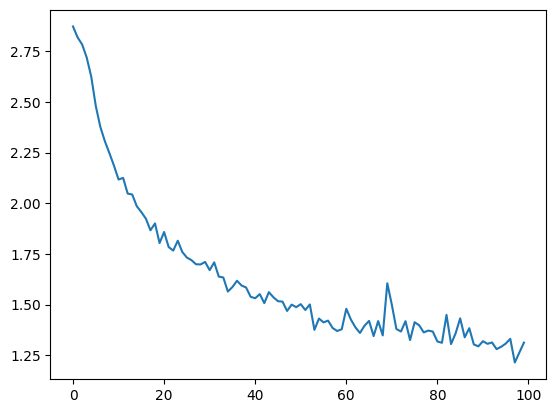

In [ ]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [ ]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)


while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(sentence)

Input:tom

> tom
English
Input:abu

> abu
Japanese
Input:ibn

> ibn
Irish
Input:fahad

> fahad
Arabic
Input:don

> don
English
Input:quit


 RNN & LSTM & *GRU*